# Malaria Detection - fastai

Much of this uses the 'out of the box' CNN model using the `fastai` library.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.version

'3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) \n[GCC 7.3.0]'

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate

In [17]:
path = pathlib.Path.home() / 'Documents' / 'sami' / 'malaria'
path

PosixPath('/home/khanms/Documents/sami/malaria')

In [18]:
path.ls()

[PosixPath('/home/khanms/Documents/sami/malaria/Untitled.ipynb'),
 PosixPath('/home/khanms/Documents/sami/malaria/.ipynb_checkpoints'),
 PosixPath('/home/khanms/Documents/sami/malaria/images')]

In [20]:
path_img = path/'images'
path_img

PosixPath('/home/khanms/Documents/sami/malaria/images')

In [23]:
path_img.ls()

[PosixPath('/home/khanms/Documents/sami/malaria/images/Parasitized'),
 PosixPath('/home/khanms/Documents/sami/malaria/images/Uninfected')]

In [24]:
help(ImageDataBunch.from_folder)

Help on method from_folder in module fastai.vision.data:

from_folder(path:Union[pathlib.Path, str], train:Union[pathlib.Path, str]='train', valid:Union[pathlib.Path, str]='valid', valid_pct=None, classes:Collection=None, **kwargs:Any) -> 'ImageDataBunch' method of builtins.type instance
    Create from imagenet style dataset in `path` with `train`,`valid`,`test` subfolders (or provide `valid_pct`).



Looking at the documentation, `ImageDataBunch.from_folder` expects the hierarchy of folders to be like so:

```
path\
  train\
    clas1\
    clas2\
    ...
  valid\
    clas1\
    clas2\
    ...
  test\
```

The default for the `train` argument is "train", this is the folder that houses the labeled folders, which in my cases is called "images." I do *not* have a pre-specified validation set/folder, so I need to pass in the `valid_pct` argument.

> Alternative approach: use the `split-folders` package in python

```
# install
!pip install split-folders

import split_folders

split_folders.ratio('images', output='images_ttv', seed=42, ratio=(.8, .1, .1)) # train, test, validation
split_folders.ratio('images', output='images_tv', seed=42, ratio=(.8, .1)) # train, validation _only_
```

In [30]:
data = ImageDataBunch.from_folder(path, train='images', ds_tfms=get_transforms(), size=224, valid_pct = 0.2
                                 ).normalize(imagenet_stats)

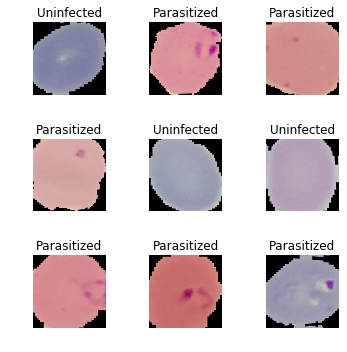

In [28]:
data.show_batch(rows=3, figsize=(5,5))

In [29]:
print(data.classes)
len(data.classes),data.c

['Parasitized', 'Uninfected']


(2, 2)

In [32]:
data

ImageDataBunch;

Train: LabelList (22047 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Parasitized,Parasitized,Parasitized,Parasitized,Parasitized
Path: /home/khanms/Documents/sami/malaria;

Valid: LabelList (5511 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Parasitized,Parasitized,Uninfected,Parasitized,Uninfected
Path: /home/khanms/Documents/sami/malaria;

Test: None

# Fit the model

In [33]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

# Use ShowGraph callback to see plot of training, validation after each epoch
# learn = cnn_learner(data, models.resnet34, metrics=accuracy, callback_fns=ShowGraph)

In [34]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [35]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.245876,0.176814,0.064598,11:12
1,0.174415,0.144639,0.053711,07:41
2,0.145995,0.130634,0.045182,07:55
3,0.135691,0.121962,0.043731,07:08
4,0.126826,0.118787,0.041916,08:20


In [36]:
learn.save('malaria_model')

# Results

In [37]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

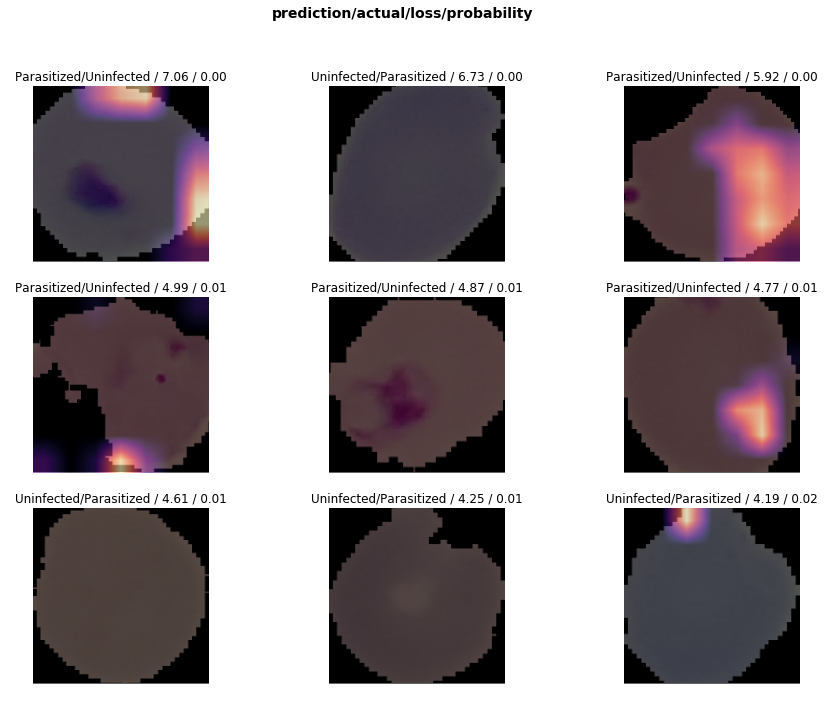

In [38]:
interp.plot_top_losses(9, figsize=(15,11))

In [43]:
interp.confusion_matrix()

array([[2570,  127],
       [ 104, 2710]])

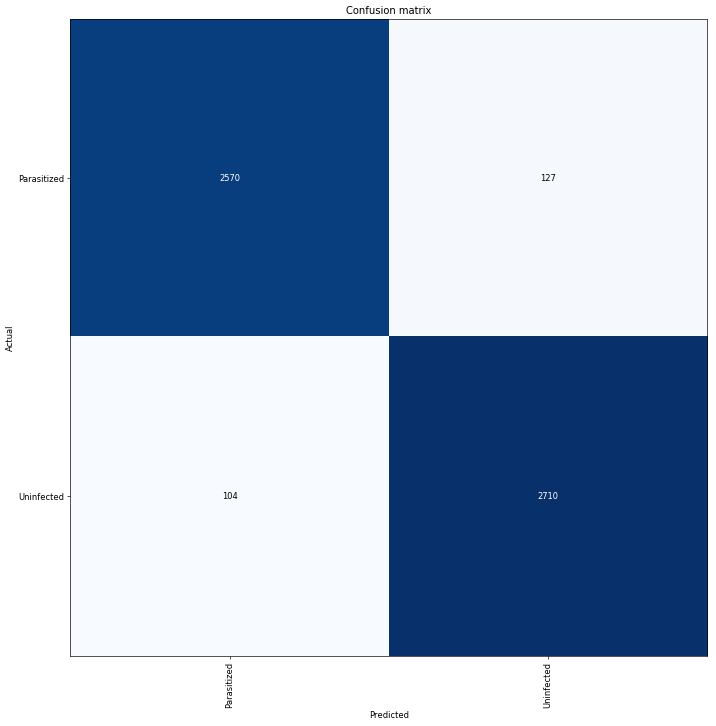

In [42]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [40]:
interp.most_confused(min_val=2)

[('Parasitized', 'Uninfected', 127), ('Uninfected', 'Parasitized', 104)]